In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.external import CellAssign
import harmonypy as hm
import numpy as np

/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
# Load the filtered matrix
adata = sc.read_10x_h5('P1858_SP140_029_76T.h5') 
adata.var_names_make_unique()
cell_markers = pd.read_csv('../CellAssign_Marker_Gene_Matrix.csv', index_col=0, sep=';')
adata 

/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 7703 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
# QC
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

# Filter cells based on mitochondrial content and gene counts
adata = adata[(adata.obs['pct_counts_mt'] < 5) & 
              (adata.obs['n_genes_by_counts'] < 5000) & 
              (adata.obs['n_genes_by_counts'] > 200), :]


/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


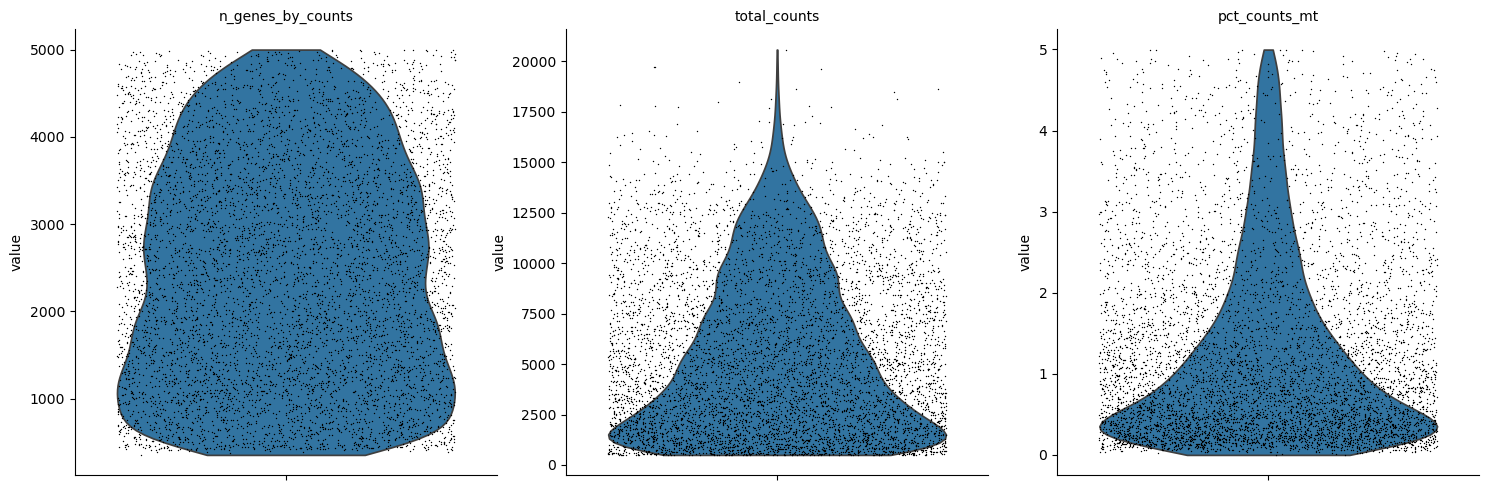

In [5]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [6]:
adata

AnnData object with n_obs × n_vars = 6215 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Create and fit CellAssign model

In [3]:
# filter the marker genes to only those that exist in the dataset
valid_markers = cell_markers.loc[adata.var_names.intersection(cell_markers.index)]

In [4]:
adata = adata[:, valid_markers.index].copy()
adata # subset only contains genes listed in the marker matrix

AnnData object with n_obs × n_vars = 7703 × 128
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
# Size factor normalization ensures that:
# correct for cell-to-cell differences in sequencing depth and capture efficiency
# Gene expression differences reflect true biological variation, not technical differences.
# Models like CellAssign get accurate likelihoods when modeling counts (negative binomial distribution assumes size-normalized counts).

# Compute size factor correctly from raw UMI counts
lib_size = adata.X.sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)

In [6]:
scvi.external.CellAssign.setup_anndata(adata, size_factor_key="size_factor")

In [11]:
Panc_76_model = CellAssign(adata, valid_markers)
Panc_76_model.train()

/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to 

Epoch 400/400: 100%|███████████████████████████| 400/400 [05:09<00:00,  1.25it/s, v_num=1, train_loss_step=75.2, train_loss_epoch=74.7]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████| 400/400 [05:09<00:00,  1.29it/s, v_num=1, train_loss_step=75.2, train_loss_epoch=74.7]


In [12]:
Panc_76_model.save("models/Panc_76_model", save_anndata=True)

In [7]:
# load the model
Panc_76_model = CellAssign.load("models/Panc_76_model/", adata=adata)
Panc_76_model

INFO     File models/Panc_76_model/model.pt already downloaded                                                     


/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/scvi/model/base/_base_model.py:694: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(


CellAssign Model with params: 
n_genes: 128, n_labels: 24
Training status: Trained

In [8]:
adata.obs["size_factor"].describe()

count    7703.000000
mean        1.000000
std         1.835841
min         0.024539
25%         0.208581
50%         0.503047
75%         1.104251
max        52.672752
Name: size_factor, dtype: float64

<Axes: xlabel='epoch'>

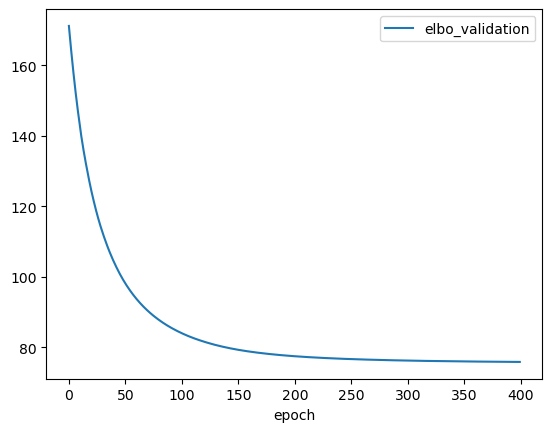

In [9]:
Panc_76_model.history["elbo_validation"].plot()

# Predict and plot assigned cell types

In [10]:
predictions = Panc_76_model.predict()
predictions.head()

,Acinar,Acinar-Reg,Acinar-i,Adipocytes,B-cell,Ductal,Endocrine,Endocrine Alpha,Endocrine Beta,Endocrine Delta,...,Intrapancreatic bile duct,Lymphatic endothelial,Lymphocytes,Macrophages,Mesothelial cells,Myelocytes,Schwann cells,Stellate,T-cell,Tuft cells
0,3.098187e-08,0.000027,2.088281e-04,8.668819e-08,2.544308e-04,1.332131e-02,1.124521e-03,8.472103e-02,8.943381e-01,4.146458e-04,...,2.104793e-07,2.315513e-05,1.023825e-05,8.388674e-04,4.096297e-08,0.001022,8.801350e-05,0.001007,1.038950e-03,1.738711e-04
1,7.076417e-08,0.000051,2.910947e-06,4.085921e-07,1.511322e-04,1.119792e-02,2.315205e-04,5.054735e-03,9.774240e-01,2.419604e-04,...,5.231358e-07,2.673652e-05,1.384260e-05,2.364221e-04,1.177291e-07,0.000666,4.502139e-04,0.002643,6.021932e-04,7.831343e-04
2,1.322247e-05,0.000286,1.700143e-07,2.053106e-05,2.410842e-04,1.607194e-03,1.281615e-04,9.251932e-04,2.140181e-01,2.090498e-03,...,2.766142e-05,9.956701e-05,2.070238e-03,2.920340e-02,2.991677e-05,0.001710,1.321854e-04,0.745750,9.851336e-04,1.423318e-04
3,9.346107e-20,0.001649,3.125675e-19,1.124882e-10,2.539142e-10,2.446336e-09,2.248396e-11,1.381594e-08,2.969616e-07,1.519531e-11,...,5.254210e-10,2.066731e-14,5.512940e-11,3.058650e-07,2.147530e-11,0.997227,4.484466e-12,0.001119,9.426863e-10,1.426466e-11
4,2.857259e-06,0.000613,3.992228e-08,3.937257e-06,3.681791e-05,2.924138e-04,1.972503e-05,5.703670e-04,3.882927e-02,3.670586e-05,...,5.604301e-06,1.681395e-05,2.381828e-04,4.739687e-04,6.922844e-06,0.000314,2.287341e-05,0.953861,4.419275e-03,2.622980e-05


/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


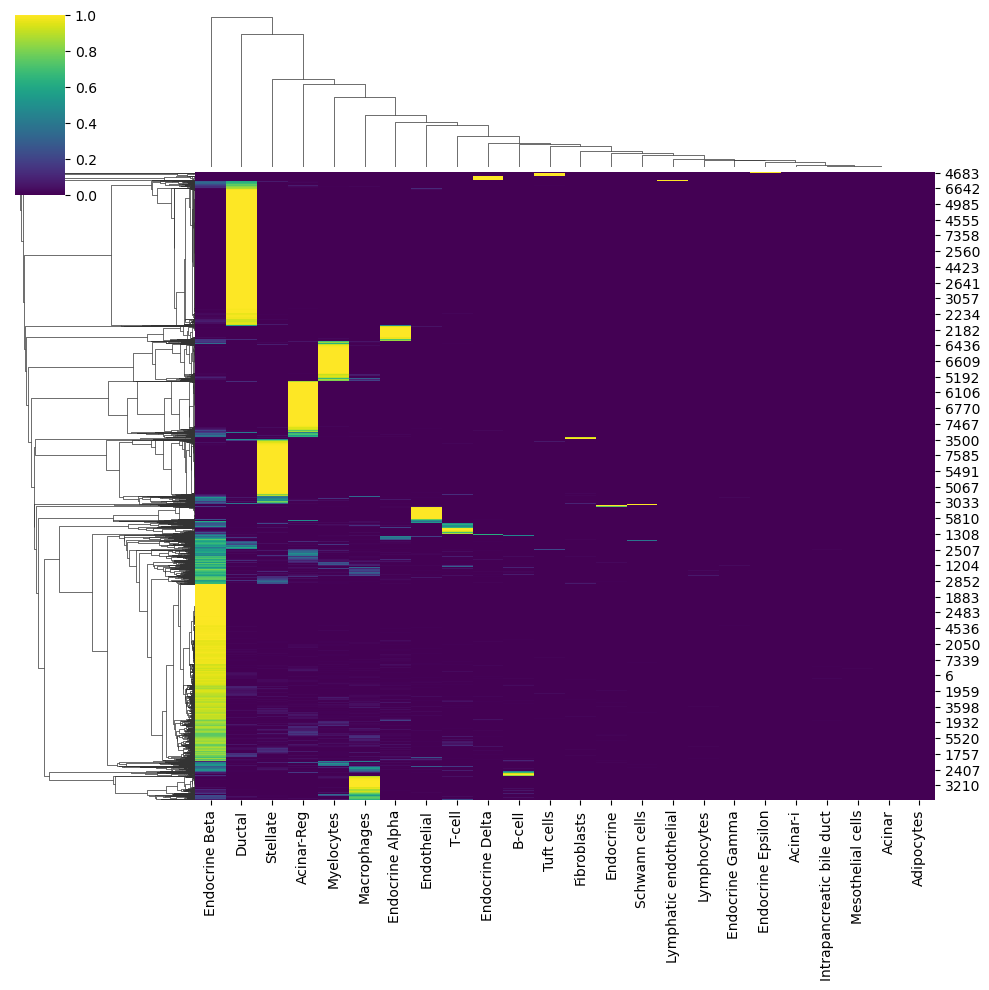

In [11]:
sns.clustermap(predictions, cmap="viridis")

In [12]:
adata.obs["cellassign_predictions"] = predictions.idxmax(axis=1).values

In [13]:
adata

AnnData object with n_obs × n_vars = 7703 × 128
    obs: 'size_factor', '_scvi_batch', 'cellassign_predictions'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: '_scvi_uuid', '_scvi_manager_uuid'

# Compare unsupervised and semi-supervised clustering

/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/var/folders/1h/fgqm53j16bl78rnmzl_s4r980000gn/T/ipykernel_5279/3136634725.py:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


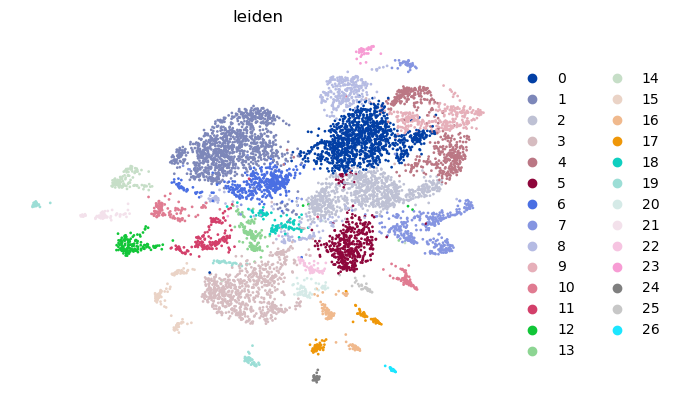

In [14]:
# Normalization for PCA
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

# PCA + neighbors + UMAP
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Leiden clustering
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=["leiden"], frameon=False)

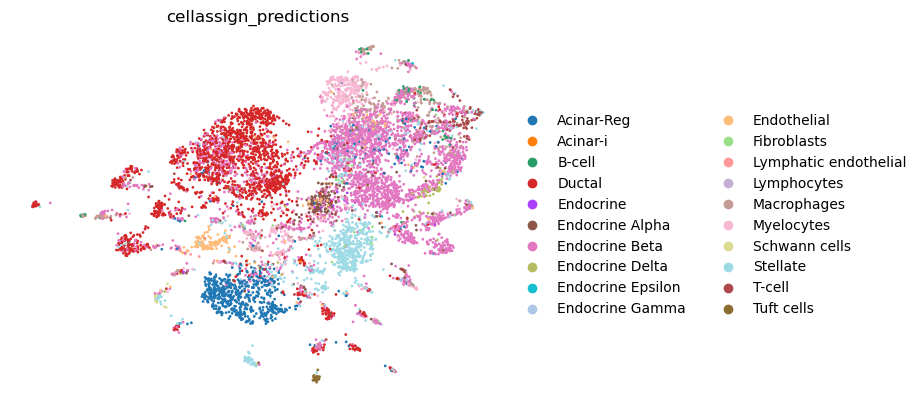

In [15]:
# celltype is the original CellAssign prediction
sc.pl.umap(adata, color=["cellassign_predictions"], frameon=False, ncols=1)

In [16]:
ductal_adata = adata[adata.obs['cellassign_predictions'] == 'Ductal'].copy()

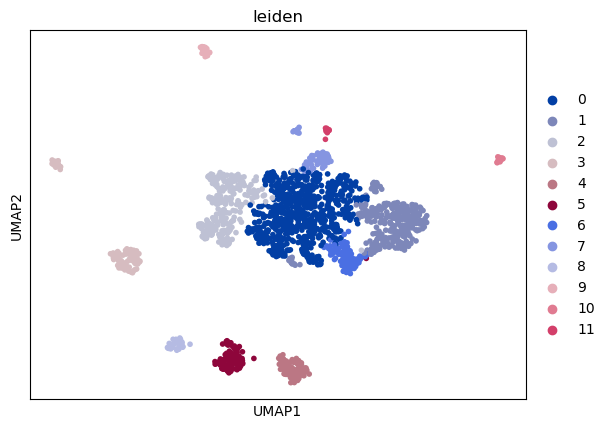

In [18]:
# Re-do neighbors, PCA and Leiden on Ductal subset
sc.pp.pca(ductal_adata, n_comps=20)
sc.pp.neighbors(ductal_adata)
sc.tl.umap(ductal_adata)
sc.tl.leiden(ductal_adata, resolution=0.25)  # You can try a slightly higher resolution

# Plot
sc.pl.umap(ductal_adata, color=['leiden'])

/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/jennytamboli/anaconda3/envs/scvi-tools/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWa

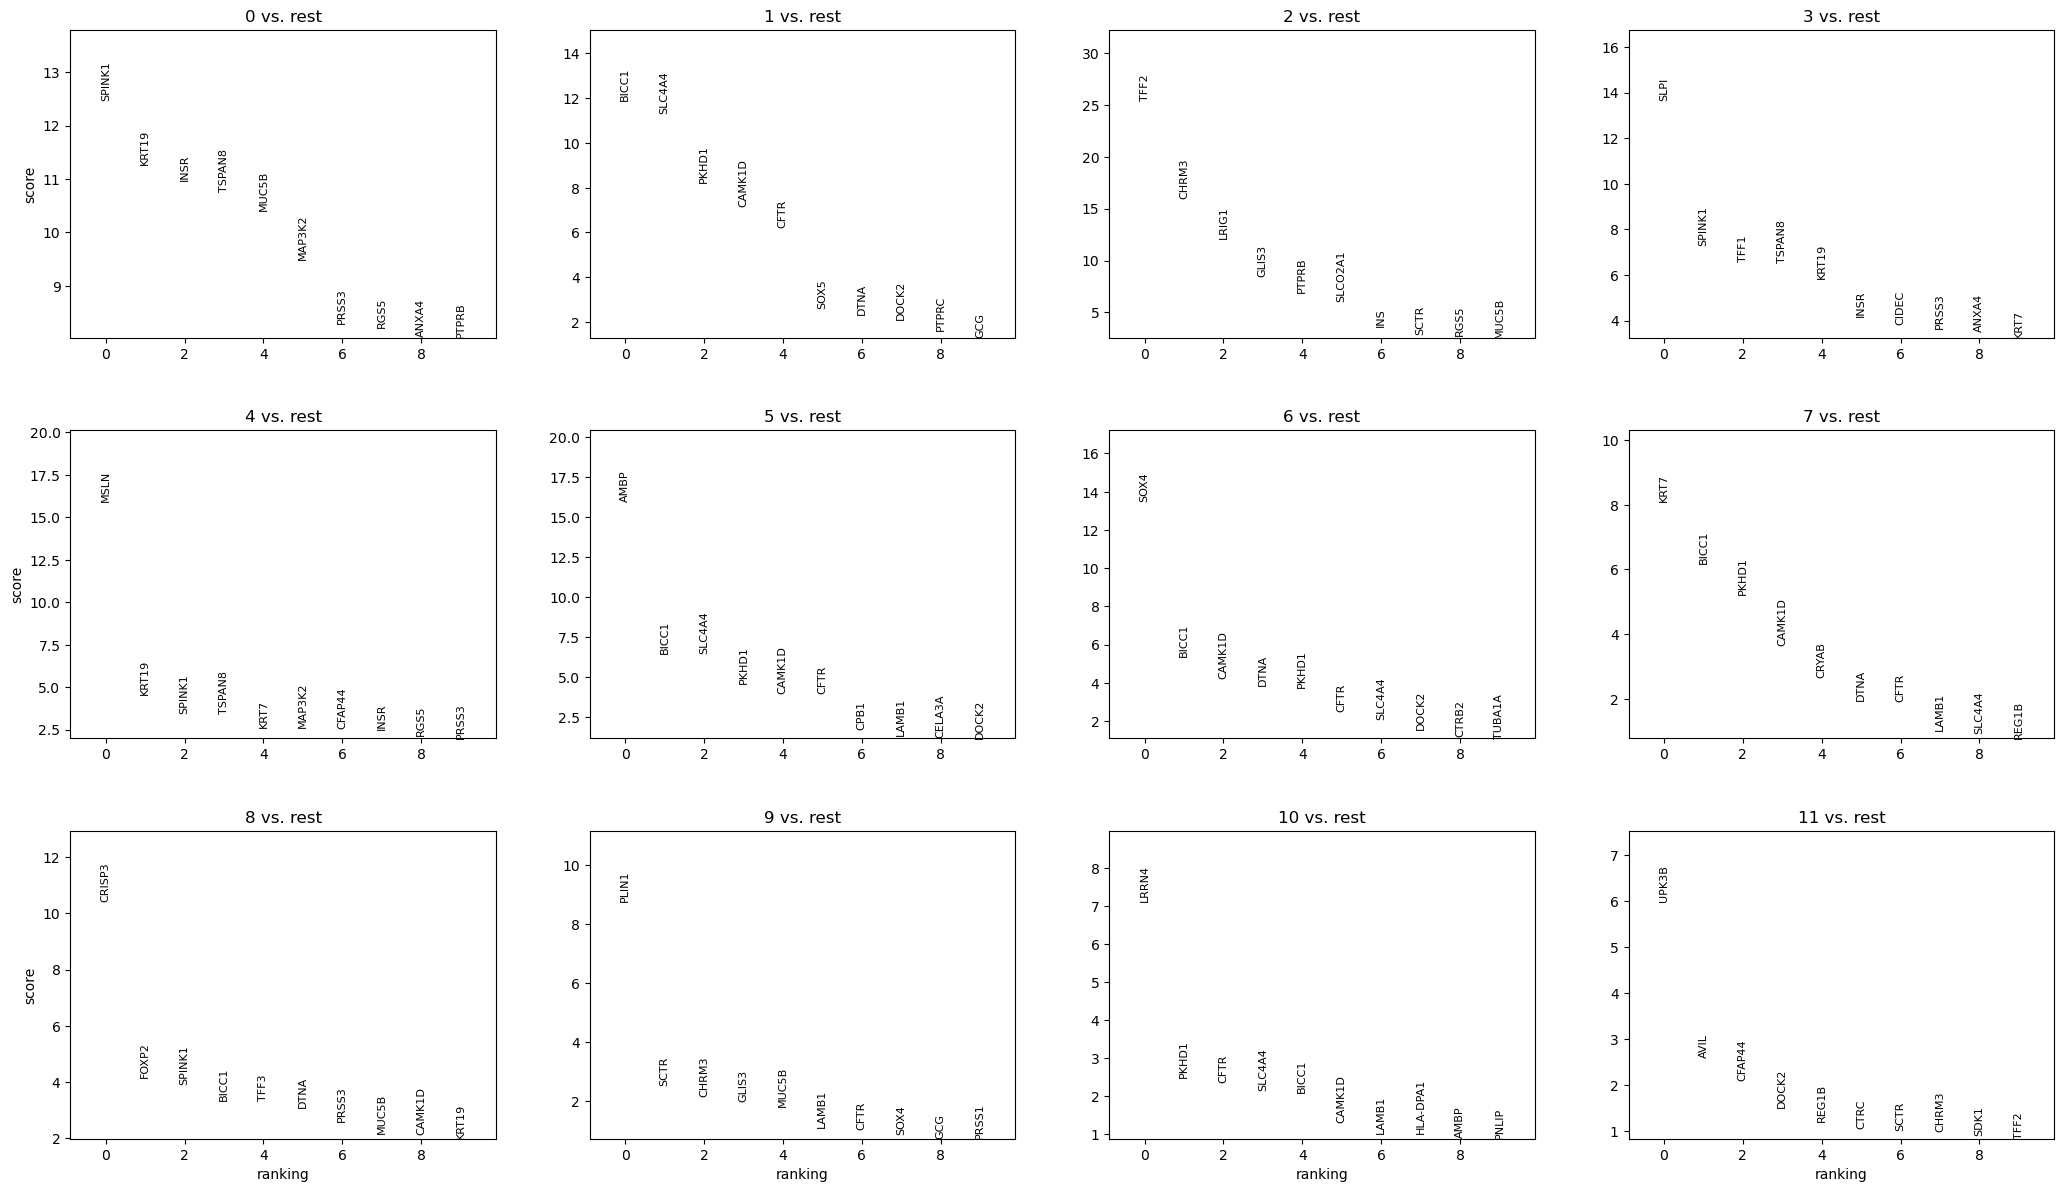

In [19]:
# Perform differential expression analysis between clusters
sc.tl.rank_genes_groups(ductal_adata, groupby='leiden', method='wilcoxon')

# Plot the top 20 ranked genes for each cluster 
sc.pl.rank_genes_groups(ductal_adata, n_genes=10, sharey=False)